# Selecting the units
#### Outline:
- 3 different overarching senarious (1-mile, 2-mile, 5-mile)
- 4 different subscenarios (optimal selection, panic selecting, highest avg price selecting, highest avg area selecting, randomly selecting)

#### Procedure:
the csv file: [N, cost_avoided, area_avoided, avg_cost_avoided, BUDGET, avg_cost/su]
- for each scenario:
    - find number of buildings protected
    - find the total avoided cost
    - find the total area avoided
    - find the average cost avoided
    - find how much of the budget was used
    - find the average cost/selection unit

In [4]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
from rasterio import open as r_open
from rasterio.plot import show as r_show 
import requests

def wf(x):
    return '/Users/dannyskahill/Documents/DS 508/project/' + x

In [18]:
om = gpd.read_file(wf('SAVED/FinalShapefiles/1_mile_radius_selection_units.shp'))
tm = gpd.read_file(wf('SAVED/FinalShapefiles/2_mile_radius_selection_units.shp'))
fm = gpd.read_file(wf('SAVED/FinalShapefiles/5_mile_radius_selection_units.shp'))

In [29]:
ca = gpd.read_file(wf('ca-state-boundary/CA_State_TIGER2016.shp'))
ca = ca.to_crs('EPSG:3310')

In [24]:
om['cb_ratio'] = om['su_cost'] / om['avoided_co']
tm['cb_ratio'] = tm['su_cost'] / tm['avoided_co']
fm['cb_ratio'] = fm['su_cost'] / fm['avoided_co']

## Create CSV

In [87]:
df = pd.DataFrame(columns=['scenario #', 'num_selection_units','num_buildings', 'cost_avoided', 'area_avoided', 
                           'avg_cost_avoided', 'budget', 'avg_num_buildings/su', 'avg_cost/su'])

In [88]:
df

,scenario #,num_selection_units,num_buildings,cost_avoided,area_avoided,avg_cost_avoided,budget,avg_num_buildings/su,avg_cost/su


In [81]:
BUDGET = 35000000

In [82]:
def generate_scenario(selection, scenario, df):
    d = {}
    d['scenario #'] = scenario
    d['num_selection_units'] = len(selection)
    d['num_buildings'] = selection['num_avoide'].sum()
    d['cost_avoided'] = selection['avoided_co'].sum()
    d['area_avoided'] = selection['avoided_m2'].sum()
    d['avg_cost_avoided'] = d['cost_avoided']/d['num_buildings']
    d['budget'] = selection['su_cost'].sum()
    d['avg_cost/su'] = d['budget']/d['num_selection_units']
    d['avg_num_buildings/su'] = d['num_buildings']/d['num_selection_units']
    return df.append(d, ignore_index=True)

### Scenario 1.1 (Optimal)

In [26]:
s1_1 = om.copy()
s1_1 = s1_1.sort_values(by='cb_ratio')
s1_1['cost_pred_sum'] = s1_1['su_cost'].cumsum()
i1_1 = s1_1['cost_pred_sum'].lt(BUDGET)

In [89]:
df = generate_scenario(s1_1[i1_1], '1m radius: c/b ratio', df)

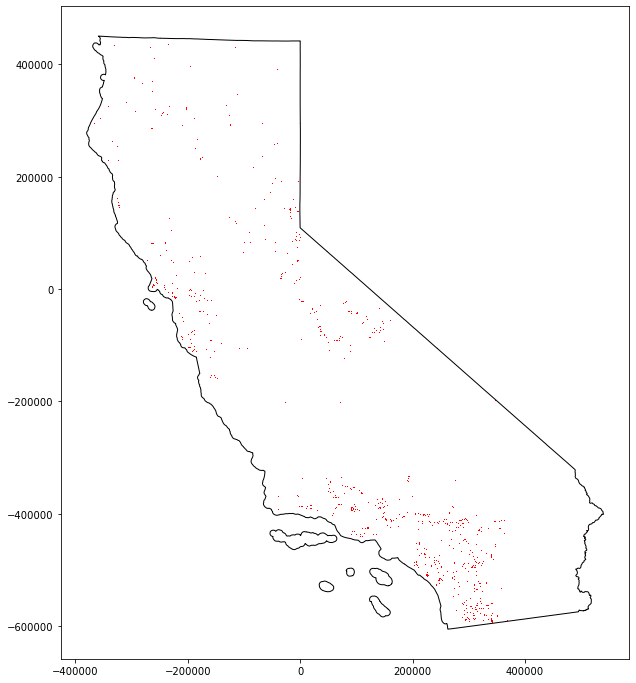

In [70]:
fig, ax = plt.subplots()
s1_1[i1_1].plot(ax=ax, color='red')
ca.plot(ax=ax, color='None', edgecolor='black')
fig.set_size_inches(15, 12)

### Scenario 1.2 (adjust threat level)

In [54]:
om['threat_lev'].describe()

count    12977.000000
mean        44.321306
std        128.456072
min        -43.087252
25%        -30.096554
50%         -4.769565
75%         67.017167
max       1325.362582
Name: threat_lev, dtype: float64

In [59]:
s1_2 = om.copy()
s1_2 = s1_2[s1_2['threat_lev'] >= 0]
s1_2 = s1_2.sort_values(by='cb_ratio')
s1_2['cost_pred_sum'] = s1_2['su_cost'].cumsum()
i1_2 = s1_2['cost_pred_sum'].lt(BUDGET)

In [90]:
df = generate_scenario(s1_2[i1_2], '1m radius: adj. threat level by c/b ratio', df)
df

,scenario #,num_selection_units,num_buildings,cost_avoided,area_avoided,avg_cost_avoided,budget,avg_num_buildings/su,avg_cost/su
0,1m radius: c/b ratio,5833,203515,9.712117e+10,4.851173e+07,477218.745824,3.499086e+07,34.890279,5998.775806
1,1m radius: adj. threat level by c/b ratio,4911,76593,2.890211e+10,1.497792e+07,377346.608754,3.499867e+07,15.596213,7126.587084


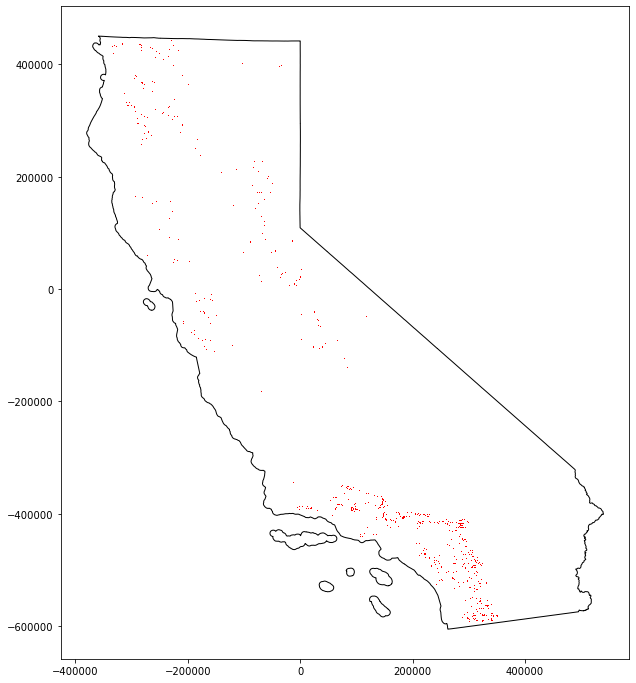

In [69]:
fig, ax = plt.subplots()
s1_2[i1_2].plot(ax=ax, color='red')
ca.plot(ax=ax, color='None', edgecolor='black')
fig.set_size_inches(15, 12)

### Scenario 1.3 (sort by threat level)

In [62]:
s1_3 = om.copy()
s1_3 = s1_3.sort_values(by='threat_lev', ascending=False)
s1_3['cost_pred_sum'] = s1_3['su_cost'].cumsum()
i1_3 = s1_3['cost_pred_sum'].lt(BUDGET)

In [91]:
df = generate_scenario(s1_3[i1_3], '1m radius: threat level priority', df)
df

,scenario #,num_selection_units,num_buildings,cost_avoided,area_avoided,avg_cost_avoided,budget,avg_num_buildings/su,avg_cost/su
0,1m radius: c/b ratio,5833,203515,9.712117e+10,4.851173e+07,477218.745824,3.499086e+07,34.890279,5998.775806
1,1m radius: adj. threat level by c/b ratio,4911,76593,2.890211e+10,1.497792e+07,377346.608754,3.499867e+07,15.596213,7126.587084
2,1m radius: threat level priority,4488,54598,1.922887e+10,1.015753e+07,352190.080695,3.499458e+07,12.165330,7797.365410


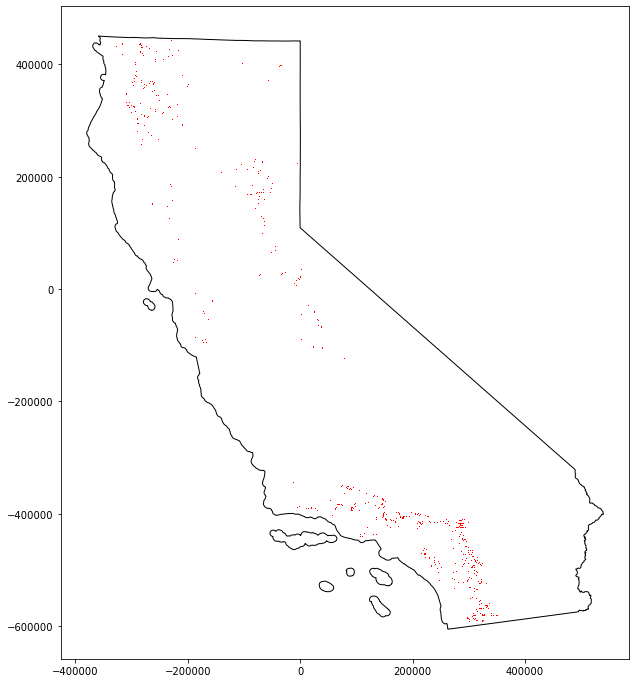

In [68]:
fig, ax = plt.subplots()
s1_3[i1_3].plot(ax=ax, color='red')
ca.plot(ax=ax, color='None', edgecolor='black')
fig.set_size_inches(15, 12)

### Scenario 1.4 (sort by highest avg avoided cost w adj threat)

In [66]:
s1_4 = om.copy()
s1_4 = s1_4[s1_4['threat_lev'] >= 0]
s1_4 = s1_4.sort_values(by='avoided_co', ascending=False)
s1_4['cost_pred_sum'] = s1_4['su_cost'].cumsum()
i1_4 = s1_4['cost_pred_sum'].lt(BUDGET)

In [92]:
df = generate_scenario(s1_4[i1_4], '1m radius: adj. threat level by avoided cost', df)
df

,scenario #,num_selection_units,num_buildings,cost_avoided,area_avoided,avg_cost_avoided,budget,avg_num_buildings/su,avg_cost/su
0,1m radius: c/b ratio,5833,203515,9.712117e+10,4.851173e+07,477218.745824,3.499086e+07,34.890279,5998.775806
1,1m radius: adj. threat level by c/b ratio,4911,76593,2.890211e+10,1.497792e+07,377346.608754,3.499867e+07,15.596213,7126.587084
2,1m radius: threat level priority,4488,54598,1.922887e+10,1.015753e+07,352190.080695,3.499458e+07,12.165330,7797.365410
3,1m radius: adj. threat level by avoided cost,4584,76191,2.885804e+10,1.492915e+07,378759.113265,3.499429e+07,16.621073,7634.006819


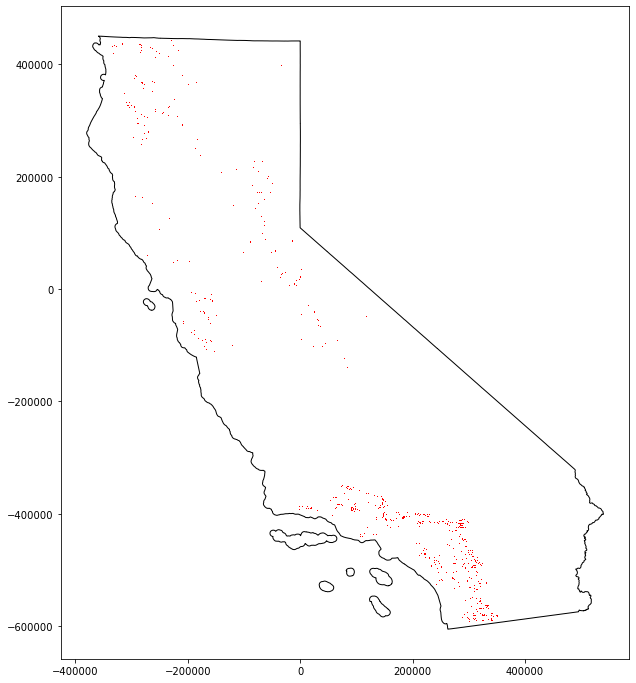

In [71]:
fig, ax = plt.subplots()
s1_4[i1_4].plot(ax=ax, color='red')
ca.plot(ax=ax, color='None', edgecolor='black')
fig.set_size_inches(15, 12)

### Scenario 1.5 (Sort by area and adj threat level)

In [73]:
s1_5 = om.copy()
s1_5 = s1_5[s1_5['threat_lev'] >= 0]
s1_5 = s1_5.sort_values(by='avoided_m2', ascending=False)
s1_5['cost_pred_sum'] = s1_5['su_cost'].cumsum()
i1_5 = s1_5['cost_pred_sum'].lt(BUDGET)

In [93]:
df = generate_scenario(s1_5[i1_5], '1m radius: adj. threat level by avoided m2', df)
df

,scenario #,num_selection_units,num_buildings,cost_avoided,area_avoided,avg_cost_avoided,budget,avg_num_buildings/su,avg_cost/su
0,1m radius: c/b ratio,5833,203515,9.712117e+10,4.851173e+07,477218.745824,3.499086e+07,34.890279,5998.775806
1,1m radius: adj. threat level by c/b ratio,4911,76593,2.890211e+10,1.497792e+07,377346.608754,3.499867e+07,15.596213,7126.587084
2,1m radius: threat level priority,4488,54598,1.922887e+10,1.015753e+07,352190.080695,3.499458e+07,12.165330,7797.365410
3,1m radius: adj. threat level by avoided cost,4584,76191,2.885804e+10,1.492915e+07,378759.113265,3.499429e+07,16.621073,7634.006819
4,1m radius: adj. threat level by avoided m2,4569,76396,2.879678e+10,1.497168e+07,376940.896881,3.499778e+07,16.720508,7659.833887


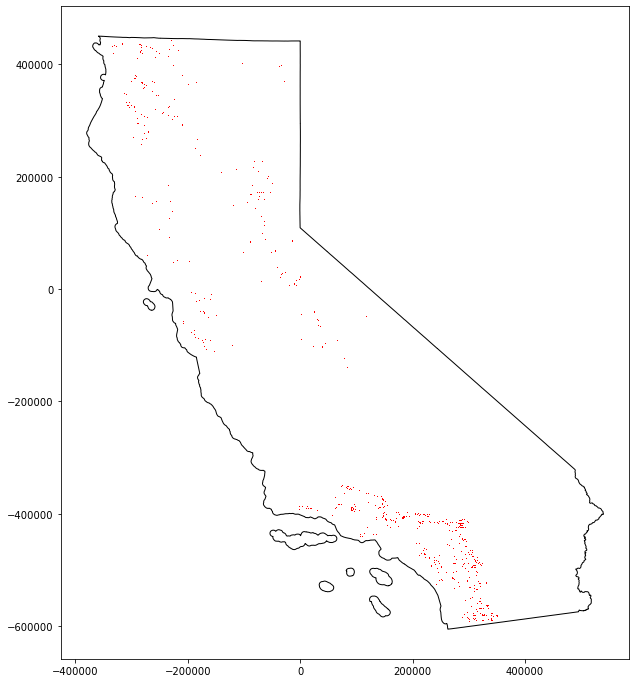

In [97]:
fig, ax = plt.subplots()
s1_5[i1_5].plot(ax=ax, color='red')
ca.plot(ax=ax, color='None', edgecolor='black')
fig.set_size_inches(15, 12)

### Scenario 1.6 (sort by num buildings and adj threat level)

In [95]:
s1_6 = om.copy()
s1_6 = s1_6[s1_6['threat_lev'] >= 0]
s1_6 = s1_6.sort_values(by='num_avoide', ascending=False)
s1_6['cost_pred_sum'] = s1_6['su_cost'].cumsum()
i1_6 = s1_6['cost_pred_sum'].lt(BUDGET)

In [96]:
df = generate_scenario(s1_6[i1_6], '1m radius: adj. threat level by num buildings', df)
df

,scenario #,num_selection_units,num_buildings,cost_avoided,area_avoided,avg_cost_avoided,budget,avg_num_buildings/su,avg_cost/su
0,1m radius: c/b ratio,5833,203515,9.712117e+10,4.851173e+07,477218.745824,3.499086e+07,34.890279,5998.775806
1,1m radius: adj. threat level by c/b ratio,4911,76593,2.890211e+10,1.497792e+07,377346.608754,3.499867e+07,15.596213,7126.587084
2,1m radius: threat level priority,4488,54598,1.922887e+10,1.015753e+07,352190.080695,3.499458e+07,12.165330,7797.365410
3,1m radius: adj. threat level by avoided cost,4584,76191,2.885804e+10,1.492915e+07,378759.113265,3.499429e+07,16.621073,7634.006819
4,1m radius: adj. threat level by avoided m2,4569,76396,2.879678e+10,1.497168e+07,376940.896881,3.499778e+07,16.720508,7659.833887
5,1m radius: adj. threat level by num buildings,4588,76758,2.866615e+10,1.489347e+07,373461.405026,3.499852e+07,16.730166,7628.273612


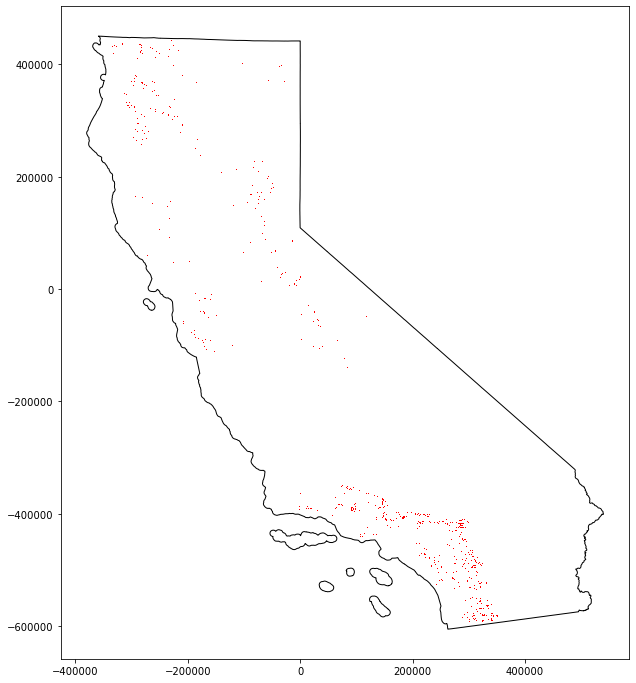

In [98]:
fig, ax = plt.subplots()
s1_6[i1_6].plot(ax=ax, color='red')
ca.plot(ax=ax, color='None', edgecolor='black')
fig.set_size_inches(15, 12)

### Scenario 1.7 (lowered threat level threshold)

In [112]:
s1_7 = om.copy()
s1_7 = s1_7[s1_7['threat_lev'] >= -5]
s1_7 = s1_7.sort_values(by='cb_ratio')
s1_7['cost_pred_sum'] = s1_7['su_cost'].cumsum()
i1_7 = s1_7['cost_pred_sum'].lt(BUDGET)

In [114]:
df = generate_scenario(s1_7[i1_7], '1m radius: adj. lowered threat level ', df)